In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from matplotlib import cm
from math import isinf
from scipy.optimize import linprog

In [22]:
class PricingEnvironment:
    def __init__(self, cost, prices, win_prob):
        self.cost = cost
        self.prices = prices
        self.win_probabilities = win_prob

    def round(self, p_t, n_t, price):
        d_t = np.random.binomial(n_t, self.win_probabilities[p_t])
        r_t = (price - self.cost)*d_t
        return d_t, r_t

In [23]:
class UCBLikeAgent():
    def __init__(self, K, B, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None # it's an index, not the actual bid
        self.avg_f = np.zeros(K)
        self.avg_c = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.budget = B
        self.rho = B/T
        self.t = 0
    
    def pull_arm(self):
        if self.budget < 1:
            return -1
        if self.t < self.K:
            self.a_t = self.t 
        else:
            f_ucbs = self.avg_f + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            c_lcbs = self.avg_c - self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)
            self.a_t = np.random.choice(self.K, p=gamma_t)
        return self.a_t

    def compute_opt(self, f_ucbs, c_lcbs):
        # If all arms appear to have zero (or negative) cost lower-bounds,
        # we fall-back to greedy on f_ucbs (but still respect budget by using LP normally).
        if np.all(c_lcbs <= 0):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1.0
            return gamma

        c = -f_ucbs
        A_ub = [c_lcbs]
        b_ub = [self.rho]
        A_eq = [np.ones(self.K)]
        b_eq = [1.0]

        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                            bounds=[(0,1)]*self.K, method='highs')
        if not res.success:
            # fallback: uniform
            gamma = np.ones(self.K) / self.K
        else:
            gamma = np.maximum(0, res.x)
            s = gamma.sum()
            gamma = gamma / s if s > 0 else np.ones(self.K)/self.K
        return gamma

    
    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        self.avg_f[self.a_t] += (f_t - self.avg_f[self.a_t])/self.N_pulls[self.a_t]
        self.avg_c[self.a_t] += (c_t - self.avg_c[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t
        self.t += 1

In [35]:
def compute_clairvoyant(prices, rho, win_probabilities, cost=0.0):
    # maximize expected reward per round: (price-cost)*win_prob
    c = - (prices - cost) * win_probabilities
    A_ub = [win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(prices))]
    b_eq = [1.0]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                           bounds=(0,1), method='highs')
    gamma = res.x
    return gamma, -res.fun


Budget:6500 valuation:<scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022D47BBFA80> n_users:12000 rho:0.5416666666666666
available bids =[0.         0.04761905 0.0952381  0.14285714 0.19047619 0.23809524
 0.28571429 0.33333333 0.38095238 0.42857143 0.47619048 0.52380952
 0.57142857 0.61904762 0.66666667 0.71428571 0.76190476 0.80952381
 0.85714286 0.9047619  0.95238095 1.        ]
gamma=[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.72140418 0.27859582
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
expected utility=0.26


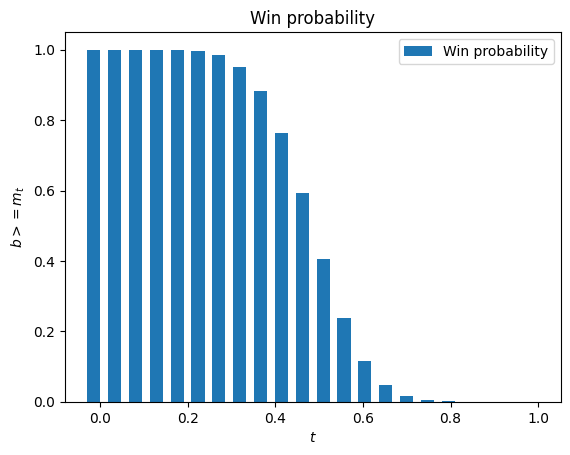

In [36]:
T = 12000
B = 6500
rho = B/T
epsilon = T**(-0.33)
K = int(1/epsilon)
prices = np.linspace(0,1,K)
valuation = stats.norm(loc=0.5, scale=0.1)
win_probabilities = 1 - valuation.cdf(prices)
gamma, expected_clairvoyant_utility = compute_clairvoyant(prices, rho, win_probabilities)

print(f'Budget:{B} valuation:{valuation} n_users:{T} rho:{rho}')
print(f'available bids ={prices}')
print(f'gamma={gamma}')
print(f'expected utility={expected_clairvoyant_utility:.2f}')
plt.title("Win probability")
width = 0.03
plt.bar(prices -width/2, win_probabilities, width=width, align='center', label='Win probability')
plt.xlabel('$t$')
plt.ylabel('$b >= m_t$')
plt.legend()
plt.show()
      

In [37]:
n_t = 1
T = 12000
B = 6500
rho = B/T
epsilon = T**(-0.33)
K = int(1/epsilon)
prices = np.linspace(0,1,K)
n_epochs = 20
all_regrets = []
all_payments = []
all_pulls = []
for i in range(n_epochs):
    valuation = stats.norm(loc=0.5, scale=0.1)
    win_probabilities = 1 - valuation.cdf(prices)
    gamma, expected_clairvoyant_utility = compute_clairvoyant(prices, rho, win_probabilities)
    
    agent = UCBLikeAgent(K, B,T, range=1)
    env = PricingEnvironment(0, prices, win_probabilities)
    
    utilities = []
    my_prices = []
    my_payments = []
    total_wins = 0

    np.random.seed(i)
    for u in range(T):
        # interaction
        index = agent.pull_arm()
        if index != -1:
            my_price = prices[index]
            c_t, f_t = env.round(index, n_t, my_price)
            agent.update(f_t, c_t)
        else:
            f_t = 0
            my_price = prices[K-1]
            c_t = 0    
        # logging
        utilities.append(f_t)
        my_prices.append(my_price)
        my_payments.append(c_t)
        total_wins+=c_t

    utilities = np.array(utilities)
    my_prices = np.array(my_prices)
    my_payments = np.array(my_payments)
    print(f'Total # of Wins: {total_wins}')
    all_regrets.append(np.cumsum(expected_clairvoyant_utility-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_pulls.append(agent.N_pulls)

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_pulls = np.array(all_pulls).mean(axis=0)
std_pulls = np.array(all_pulls).std(axis=0)



Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\digio\AppData\Local\Temp\ipykernel_19904\3233678207.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')
C:\Users\digio\AppData\Local\Temp\ipykernel_19904\3233678207.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


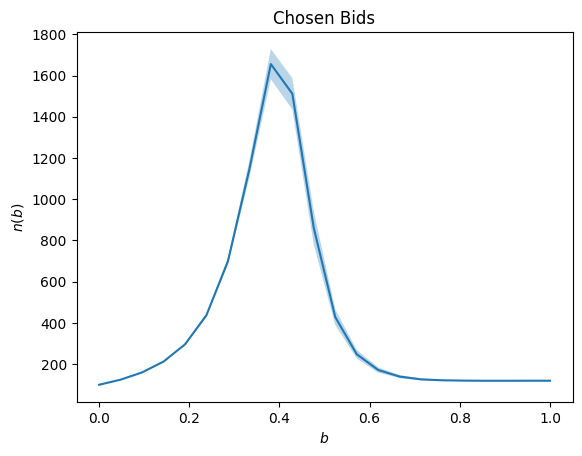

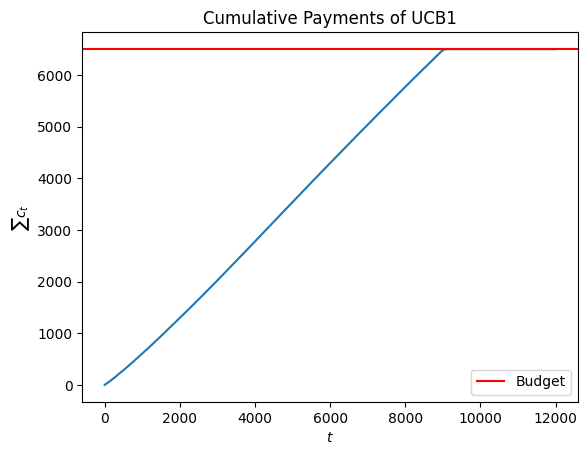

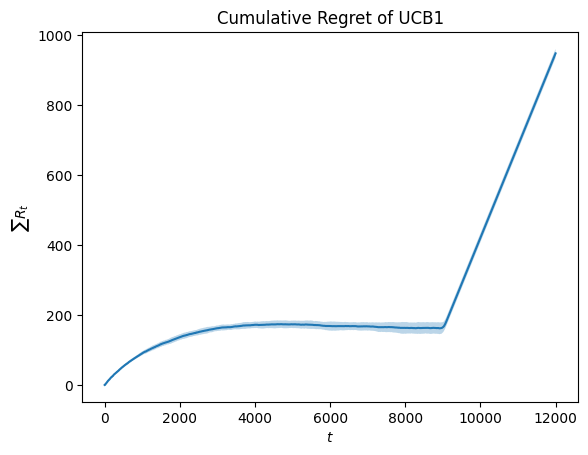

In [38]:
plt.plot(prices, avg_pulls)
plt.fill_between(prices, avg_pulls-std_pulls, avg_pulls+std_pulls, alpha=0.3)
plt.plot()
plt.xlabel('$b$')
plt.ylabel('$n(b)$')
plt.title('Chosen Bids')
plt.show()

plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB1')
plt.show()

plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of UCB1')
plt.show()